# Ensamble Classifiers

In [10]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from collections import defaultdict
from itertools import cycle
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
# hyperparameter tuning ## To search for the most suitable parameters for the Decision Tree
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from yellowbrick import ROCAUC
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn import tree
from IPython.display import Image
from sklearn.metrics import confusion_matrix
import pydotplus


## Data Preparation

In [2]:
X_train = pd.read_csv("/Users/salvu/Desktop/DM2Git/2Modulo/X_train.txt", header=None,  delim_whitespace=True)
y_train = pd.read_csv("/Users/salvu/Desktop/DM2Git/2Modulo/y_train.txt", header=None, delim_whitespace=True )
X_test = pd.read_csv("/Users/salvu/Desktop/DM2Git/2Modulo/X_test.txt", header=None, delim_whitespace=True )
y_test = pd.read_csv("/Users/salvu/Desktop/DM2Git/2Modulo/y_test.txt", header=None, delim_whitespace=True )
subject_train = pd.read_csv("/Users/salvu/Desktop/DM2Git/2Modulo/subject_train.txt", header=None, delim_whitespace=True )
features = pd.read_csv("/Users/salvu/Desktop/DM2Git/2Modulo/features.txt", header=None, delim_whitespace=True )

In [3]:
feature = features
feature.drop(0,inplace=True, axis=1)

In [4]:
#inseriamo l'intestazione al dataset
lista=[]
feat_transpa = feature.transpose()
for i in range(561):
    lista.append(feat_transpa.iloc[0][i])
X_test.columns=lista    
X_train.columns=lista

In [5]:
# eliminiamo le colonne che contengono la stima mad in quanto quasi uguale a dev.std
stringa="mad()"
for col in X_train.columns:
    if(stringa in col):
        X_train.drop(labels=col, axis=1, inplace=True)
for col in X_test.columns:
    if(stringa in col):
        X_test.drop(labels=col, axis=1, inplace=True)
#for col in features:
#    if (stringa in col):
#        features.drop(labels=col,axis=1,inplace=True)

## Random Forest

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import permutation_importance

In [7]:
clf = RandomForestClassifier(max_depth=None, min_samples_leaf= 1, min_samples_split=4,
                             n_estimators=400, max_features='log2', n_jobs=-1, criterion ='entropy')
clf.fit(X_train, np.ravel(y_train))

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9355276552426196
F1-score [0.93059629 0.90416667 0.89001264 0.93107105 0.94106981 1.        ]
              precision    recall  f1-score   support

           1       0.90      0.96      0.93       496
           2       0.89      0.92      0.90       471
           3       0.95      0.84      0.89       420
           4       0.97      0.89      0.93       491
           5       0.91      0.98      0.94       532
           6       1.00      1.00      1.00       537

    accuracy                           0.94      2947
   macro avg       0.94      0.93      0.93      2947
weighted avg       0.94      0.94      0.94      2947



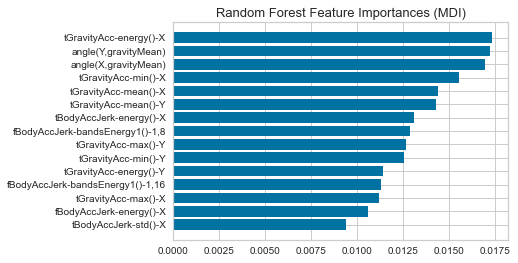

In [11]:
# Feature Importance
nbr_features = 15

tree_feature_importances = clf.feature_importances_
sorted_idx = tree_feature_importances.argsort()[-nbr_features:]

y_ticks = np.arange(0, len(sorted_idx))
fig, ax = plt.subplots()
plt.barh(y_ticks, tree_feature_importances[sorted_idx])
plt.yticks(y_ticks, np.array(X_train.columns)[sorted_idx])
plt.title("Random Forest Feature Importances (MDI)", size=13)
plt.show()

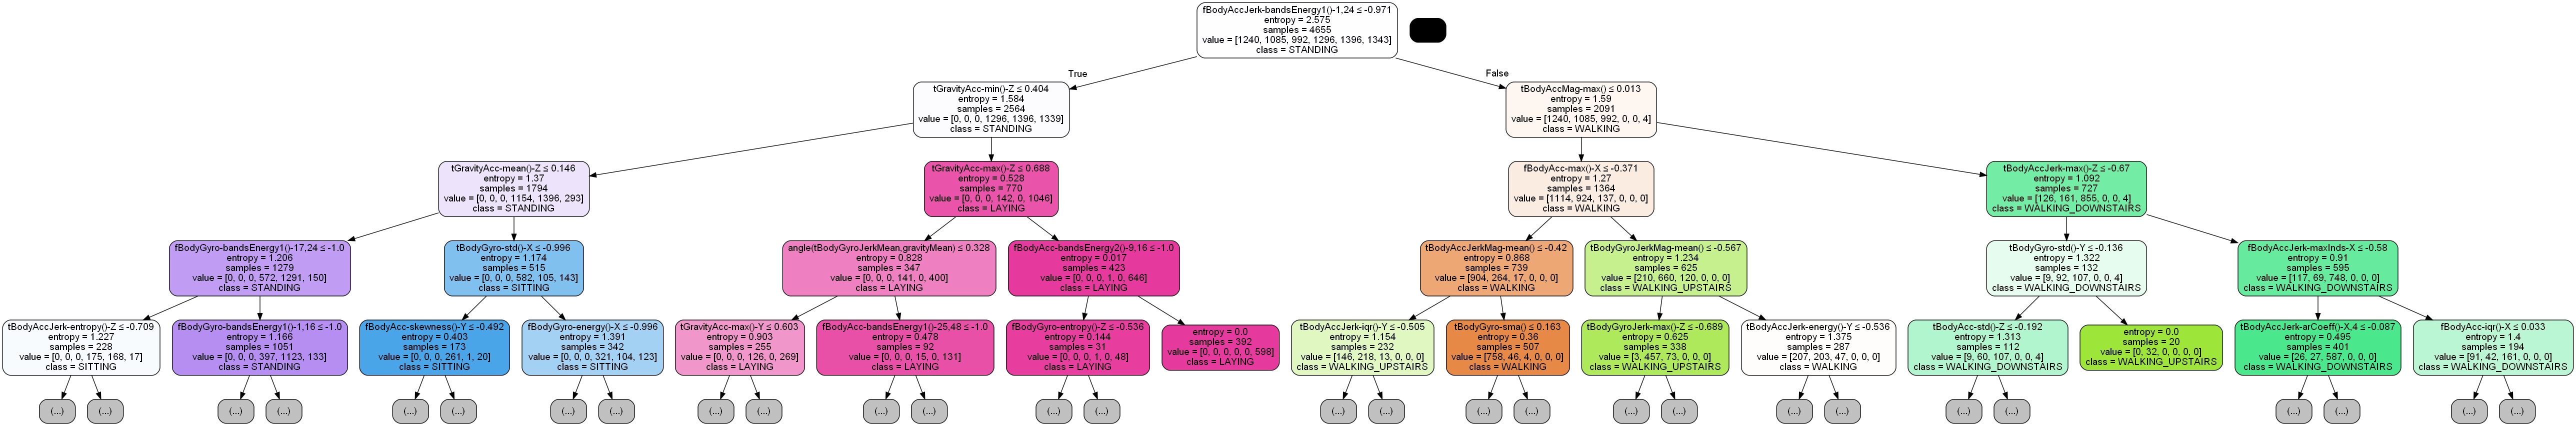

In [21]:
# Plot Albero 0
dot_data = tree.export_graphviz(clf.estimators_[0], out_file=None,  
                                feature_names=X_train.columns, 
                                class_names=["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS", "SITTING", "STANDING", "LAYING" ],  
                                filled=True, rounded=True,  
                                special_characters=True, max_depth=4)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

### Tuning the hyper-parameters

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [23]:
param_list = {'max_depth': [None],    
             'min_samples_split': [2, 4, 7, 10, 15],
             'min_samples_leaf': [1, 2, 3, 5, 10], 
             'criterion': ['entropy'],
             'max_features': ['auto', 'sqrt', 'log2'],
             'n_estimators' : [5,20,50,100,200,300,400]
             }

In [ ]:
grid_search = GridSearchCV(clf, param_grid=param_list, cv=5, n_jobs=-1)
grid_search.fit(X_train, np.ravel(y_train))
clf_gs = grid_search.best_estimator_

In [ ]:
clf_gs = grid_search.best_estimator_
clf_gs

In [ ]:
grid_search.best_params_

### Roc Curve

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
from yellowbrick import ROCAUC

In [25]:
#Binarize FARE ATTENZIONE PERCHE' DOPO SBALLA LE CLASSI
y_test1 = label_binarize(y_test, classes=[1,2,3,4,5,6])
y_train1 = label_binarize(y_train, classes=[1,2,3,4,5,6])

In [26]:
# Learn to predict each class against the other
classifier = OneVsRestClassifier(clf)   
classifier.fit(X_train, y_train1)
y_pred = classifier.predict(X_test)
y_pred_proba = classifier.predict_proba(X_test)

In [27]:
# Compute ROC curve and ROC area for each class
CLASS_LABELS = [ "WALKING" , "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS", "SITTING", "STANDING", "LAYING"]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(CLASS_LABELS)):
    fpr[i], tpr[i], _ = roc_curve(y_test1[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

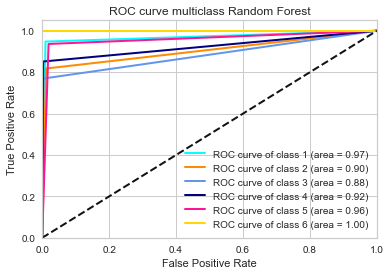

In [28]:
#plot
lw=2
colors = cycle(["aqua", "darkorange", "cornflowerblue","navy", "deeppink", "gold"])
for i, color in zip(range(len(CLASS_LABELS)), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i+1, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve multiclass Random Forest")
plt.legend(loc="lower right")
plt.show()

## Bagging

In [30]:
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier

# Base estimator con DecTree, SVC o Rand forest

In [32]:
clf1 = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=20, random_state=0)
clf1.fit(X_train, np.ravel(y_train))

y_pred = clf1.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9005768578215134
F1-score [0.91204589 0.84302964 0.88861689 0.86514523 0.87985213 1.        ]
              precision    recall  f1-score   support

           1       0.87      0.96      0.91       496
           2       0.87      0.82      0.84       471
           3       0.91      0.86      0.89       420
           4       0.88      0.85      0.87       491
           5       0.87      0.89      0.88       532
           6       1.00      1.00      1.00       537

    accuracy                           0.90      2947
   macro avg       0.90      0.90      0.90      2947
weighted avg       0.90      0.90      0.90      2947



In [33]:
clf = BaggingClassifier(base_estimator=SVC(C=1000), n_estimators=20, random_state=0, n_jobs=-1)
clf.fit(X_train, np.ravel(y_train))

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9657278588394977
F1-score [0.97222222 0.95798319 0.96568627 0.94351464 0.95220588 1.        ]
              precision    recall  f1-score   support

           1       0.96      0.99      0.97       496
           2       0.95      0.97      0.96       471
           3       0.99      0.94      0.97       420
           4       0.97      0.92      0.94       491
           5       0.93      0.97      0.95       532
           6       1.00      1.00      1.00       537

    accuracy                           0.97      2947
   macro avg       0.97      0.96      0.97      2947
weighted avg       0.97      0.97      0.97      2947



## Boosting

In [34]:
from sklearn.ensemble import AdaBoostClassifier

In [36]:
clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=10, random_state=0)
clf.fit(X_train, np.ravel(y_train))

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.8540889039701391
F1-score [0.85322896 0.78101402 0.84606061 0.79787234 0.82820976 1.        ]
              precision    recall  f1-score   support

           1       0.83      0.88      0.85       496
           2       0.79      0.77      0.78       471
           3       0.86      0.83      0.85       420
           4       0.84      0.76      0.80       491
           5       0.80      0.86      0.83       532
           6       1.00      1.00      1.00       537

    accuracy                           0.85      2947
   macro avg       0.85      0.85      0.85      2947
weighted avg       0.85      0.85      0.85      2947



### Tuning the hyper-parameters

In [ ]:
#GS adaboostclassif
abc = AdaBoostClassifier(base_estimator=RandomForestClassifier(max_depth=None, min_samples_leaf= 1, min_samples_split=4,
                                                               n_estimators=400, max_features='log2'), random_state=1)

parameters = {'n_estimators':list(range(40, 400, 20)), 
              'learning_rate':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}

gs = GridSearchCV(abc, parameters, scoring='accuracy', cv=5, n_jobs=-1)
gs.fit(X_train, np.ravel(y_train))

In [ ]:
print("Optimal hyperparameter combination:", gs.best_params_)

In [37]:
clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=42), n_estimators=220, learning_rate = 0.1, random_state=0)
clf.fit(X_train, np.ravel(y_train))

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.8540889039701391
F1-score [0.85322896 0.78101402 0.84606061 0.79787234 0.82820976 1.        ]
              precision    recall  f1-score   support

           1       0.83      0.88      0.85       496
           2       0.79      0.77      0.78       471
           3       0.86      0.83      0.85       420
           4       0.84      0.76      0.80       491
           5       0.80      0.86      0.83       532
           6       1.00      1.00      1.00       537

    accuracy                           0.85      2947
   macro avg       0.85      0.85      0.85      2947
weighted avg       0.85      0.85      0.85      2947



##  Gradient Boosting

Accuracy 0.8540889039701391
F1-score [0.85322896 0.78101402 0.84606061 0.79787234 0.82820976 1.        ]
              precision    recall  f1-score   support

           1       0.93      0.98      0.96       496
           2       0.94      0.94      0.94       471
           3       0.97      0.90      0.93       420
           4       0.93      0.90      0.92       491
           5       0.91      0.94      0.93       532
           6       1.00      1.00      1.00       537

    accuracy                           0.95      2947
   macro avg       0.95      0.94      0.95      2947
weighted avg       0.95      0.95      0.95      2947



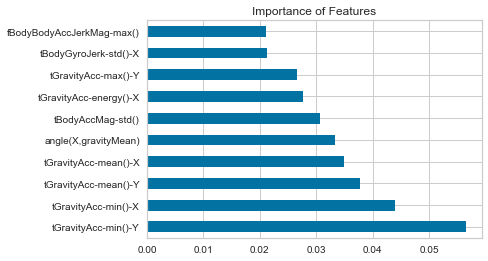

In [38]:
#FEATURE IMPORTANCES + CLASSIFICATION REPORT
from sklearn.ensemble import GradientBoostingClassifier

baseline = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100,max_depth=3, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10)
baseline.fit(X_train,np.ravel(y_train[0]))
predictors=list(X_train)
feat_imp = pd.Series(baseline.feature_importances_, predictors).sort_values(ascending=False)
feat_imp[:10].plot(kind='barh', title='Importance of Features')

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
pred=baseline.predict(X_test)
print(classification_report(y_test, pred))

### Tuning the hyper-parameters

In [ ]:
params = { 'max_depth': [3,6,10],
           'learning_rate': [0.01, 0.05, 0.1],
           'n_estimators': [100, 500],
          'max_features': ['auto', 'sqrt', 'log2']
           }

model = GradientBoostingClassifier(n_estimators=100, random_state=100)

In [ ]:
model_grid_search = GridSearchCV(model, param_grid=params,
                                 n_jobs=-1, cv=3)
model_grid_search.fit(X_train, np.ravel(y_train[0]))

In [ ]:
model_grid_search.best_params_

In [39]:
clf = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.1, max_depth=3, max_features='log2', random_state=0)
clf.fit(X_train, y_train[0])

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9491007804546997
F1-score [0.95712861 0.93416928 0.94103194 0.9232387  0.93333333 1.        ]
              precision    recall  f1-score   support

           1       0.95      0.97      0.96       496
           2       0.92      0.95      0.93       471
           3       0.97      0.91      0.94       420
           4       0.95      0.89      0.92       491
           5       0.91      0.96      0.93       532
           6       1.00      1.00      1.00       537

    accuracy                           0.95      2947
   macro avg       0.95      0.95      0.95      2947
weighted avg       0.95      0.95      0.95      2947



## HistGradientBoostingClassifier


In [40]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

c:\anaconda3n\lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [ ]:
from sklearn.model_selection import GridSearchCV

model=HistGradientBoostingClassifier(random_state=42, max_leaf_nodes=4)

param_grid = {
    'learning_rate': [0.01, 0.1, 1],
    'max_leaf_nodes': [3,10,15,30],
    'max_depth' : [3,6,10],
    'max_bins' : [50,100,150]
}
model_grid_search = GridSearchCV(model, param_grid=param_grid,
                                 n_jobs=-1, cv=3)
model_grid_search.fit(X_train, np.ravel(y_train[0]))

In [ ]:
model_grid_search.best_params_

In [41]:
clf = HistGradientBoostingClassifier(max_iter=100, learning_rate=0.1,
                                     max_depth=3, max_bins=150, # max
                                     random_state=0, max_leaf_nodes=3, loss='categorical_crossentropy')
clf.fit(X_train, np.ravel(y_train[0]))

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

c:\anaconda3n\lib\site-packages\sklearn\ensemble\_hist_gradient_boosting\gradient_boosting.py:1823: FutureWarning: The loss 'categorical_crossentropy' was deprecated in v1.1 and will be removed in version 1.3. Use 'log_loss' which is equivalent.
  warnings.warn(


Accuracy 0.9446895147607737
F1-score [0.95339806 0.92307692 0.94320988 0.91553702 0.92718894 1.        ]
              precision    recall  f1-score   support

           1       0.92      0.99      0.95       496
           2       0.93      0.92      0.92       471
           3       0.98      0.91      0.94       420
           4       0.94      0.89      0.92       491
           5       0.91      0.95      0.93       532
           6       1.00      1.00      1.00       537

    accuracy                           0.94      2947
   macro avg       0.95      0.94      0.94      2947
weighted avg       0.95      0.94      0.94      2947



## XGBoost

In [42]:
!pip install xgboost

In [51]:
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")

In [52]:
import xgboost as xgb
#TUNING ATTENZIONE CHE LE LABEL DEVONO PARTIRE DA 0 PER QUESTO USIAMO Y_TEST E TRAIN ["NEW"]

diz= {1:0,2:1,3:2,4:3,5:4,6:5}
y_test["new"] = y_test[0].map(diz)
y_train["new"] = y_train[0].map(diz)

#learning_rate [0.05, 0.1]
#max_depth= [3,6,10]
#min_child_weight = 1, 3, 6
#gamma = 0 : A smaller value like 0.1-0.2 can also be chosen for starting.
#colsample_bytree = 0.8 : This is a commonly used used start value. Typical values range between 0.5-0.9.
##DOPO AVER IMPOSTATO QUESTI PARAMETRI PER TUNING VEDIAMO DI REGOLARIZZARE L'OVERFITTING

#reg_alpha [1e-5, 1e-2, 0.1, 1, 100] Nel nostro caso lasciandolo di default

#objective='multi:softmax' to multiclass prediction

xgb_model = xgb.XGBClassifier(booster = 'gbtree', random_state=0, objective='multi:softmax',
                              gamma = 0.1, max_depth=3,  min_child_weight=1,
                              use_label_encoder=False, eta=0.4)

xgb_model.fit(X_train, np.ravel(y_train["new"]), eval_metric='mlogloss')
y_pred = xgb_model.predict(X_test)

#Check overfitting
#print('Training set score: {:.4f}'.format(xgb_model.score(X_train, y_train["new"])))
#print('Test set score: {:.4f}'.format(xgb_model.score(X_test, y_test["new"])))

print('Accuracy %s' % accuracy_score(y_test["new"], y_pred))
print('F1-score %s' % f1_score(y_test["new"], y_pred, average=None))
print(classification_report(y_test["new"], y_pred))

Accuracy 0.9494401085850017
F1-score [0.96933729 0.93657505 0.95365854 0.90909091 0.92433911 1.        ]
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       496
           1       0.93      0.94      0.94       471
           2       0.98      0.93      0.95       420
           3       0.95      0.88      0.91       491
           4       0.90      0.95      0.92       532
           5       1.00      1.00      1.00       537

    accuracy                           0.95      2947
   macro avg       0.95      0.95      0.95      2947
weighted avg       0.95      0.95      0.95      2947



## LightGBM

In [53]:
from lightgbm import LGBMClassifier
#bisogna levare caretteri speciali dai nomi delle features altrimenti si rompe
import re
X_train = X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_test = X_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))


In [54]:
clf = LGBMClassifier(boosting_type='gbdt',  #'goss', #'dart'
                     max_depth=-1, # no limit
                     num_leaves=31,
                     n_estimators=100,
                     subsample_for_bin=200000,
                     objective='multiclass',
                     reg_alpha=0.0, #L1 regularization term on weights
                     reg_lambda=0.0, #L2 regularization term on weights
                     random_state=42
                   )
clf.fit(X_train, np.ravel(y_train["new"]))

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test["new"], y_pred))
print('F1-score %s' % f1_score(y_test["new"], y_pred, average=None))
print(classification_report(y_test["new"], y_pred))

Accuracy 0.9345096708517137
F1-score [0.95771878 0.93062967 0.94878049 0.87229437 0.89483066 1.        ]
              precision    recall  f1-score   support

           0       0.93      0.98      0.96       496
           1       0.94      0.93      0.93       471
           2       0.97      0.93      0.95       420
           3       0.93      0.82      0.87       491
           4       0.85      0.94      0.89       532
           5       1.00      1.00      1.00       537

    accuracy                           0.93      2947
   macro avg       0.94      0.93      0.93      2947
weighted avg       0.94      0.93      0.93      2947



In [55]:
import lightgbm as lgb
clf = LGBMClassifier()
clf.fit(X_train, y_train[0])
y_pred=clf.predict(X_test)

### Tuning the hyper-parameters

In [ ]:
#1 num_leaves : This is the main parameter to control the complexity of the tree model. Ideally, the value of num_leaves should be less than or equal to 2^(max_depth). Value more than this will result in overfitting.

#2 min_data_in_leaf : Setting it to a large value can avoid growing too deep a tree, but may cause under-fitting. In practice, setting it to hundreds or thousands is enough for a large dataset.

#3 max_depth : We also can use max_depth to limit the tree depth explicitly.

#FOR FASTER SPEED
#Use bagging by setting bagging_fraction and bagging_freq.
#Use feature sub-sampling by setting feature_fraction.
#Use small max_bin.
#Use save_binary to speed up data loading in future learning.

#FOR BETTER ACCURACY
#Use large max_bin (may be slower).
#Use small learning_rate with large num_iterations
#Use large num_leaves(may cause over-fitting)
#Use bigger training data
#Try dart
#Try to use categorical feature directly

#TO DEAL WITH OVER FITTING
#Use small max_bin
#Use small num_leaves
#Use min_data_in_leaf and min_sum_hessian_in_leaf
#Use bagging by set bagging_fraction and bagging_freq
#Use feature sub-sampling by set feature_fraction
#Use bigger training data
#Try lambda_l1, lambda_l2 and min_gain_to_split to regularization
#Try max_depth to avoid growing deep tree

In [56]:
#!pip install scikit_optimize
params = {
          'boosting_type': 'gbdt',
          'objective': 'multiclass',
          'metric': 'multi_logloss',
          'num_class':6,
          'max_depth':3,
          'learning_rate': 0.2,
          'n_estimators':150,
          'max_bins' : 8,
          'min_split_gain' : 0.2,
          'min_child_samples':600
         ## REDUCE OVERFITTING
         #'min_data_in_leaf':[50], #primo parametro per ridurre overifitting
         #'colsample_bytree': [0.0], #altri 3 parametri per ridurre overfitt
         #'min_split_gain' : [0.0],
         #'subsample' : [1],
         #'reg_lambda' : 0.5,
         #'reg_alpha': 1, # fattore di regolarizzazione semper per overfitting
         }
          #quando non c'è molta differenza di score tra
          #train e test, we can adjust the max_depth and num_leaves parameter to reduce overfitting.
           

clf = LGBMClassifier(**params)

clf.fit(X_train, y_train[0])
y_pred=clf.predict(X_test)

#Check OVERFITTING --> SE l'accuratezza del modello differisce di molto dal test rispetto al train siamo in overfitting
#print('Training set score: {:.4f}'.format(clf.score(X_train, y_train[0])))
#print('Test set score: {:.4f}'.format(clf.score(X_test, y_test[0])))

print('Accuracy %s' % accuracy_score(y_test[0], y_pred))
print('F1-score %s' % f1_score(y_test[0], y_pred, average=None))
print (classification_report(y_test[0], y_pred))

Accuracy 0.9681031557516118
F1-score [0.97425743 0.95922747 0.97601918 0.94450262 0.95316804 1.        ]
              precision    recall  f1-score   support

           1       0.96      0.99      0.97       496
           2       0.97      0.95      0.96       471
           3       0.98      0.97      0.98       420
           4       0.97      0.92      0.94       491
           5       0.93      0.98      0.95       532
           6       1.00      1.00      1.00       537

    accuracy                           0.97      2947
   macro avg       0.97      0.97      0.97      2947
weighted avg       0.97      0.97      0.97      2947



In [ ]:
#PLOT CHECK OVERFITTING (in questo caso lo vediamo al variare della depth, ma possiamo impostare un qualsiasi valore)
from matplotlib import pyplot

# define lists to collect scores
#rain_scores, test_scores = list(), list()
# define the tree depths to evaluate
#alues = [i for i in range(1, 21)]
# evaluate a decision tree for each depth
#or i in values:
#   # configure the model
#   model = LGBMClassifier(max_depth=i)
#   # fit model on the training dataset
#   model.fit(X_train, np.ravel(y_train[0]))
#   # evaluate on the train dataset
#   train_yhat = model.predict(X_train)
#   train_acc = accuracy_score(y_train[0], train_yhat)
#   train_scores.append(train_acc)
#   # evaluate on the test dataset
#   test_yhat = model.predict(X_test)
#   test_acc = accuracy_score(y_test[0], test_yhat)
#   test_scores.append(test_acc)
#   # summarize progress
#   print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))
#   # pot of train and test scores vs tree depth
pyplot.plot(values, train_scores, '-o', label='Train')
pyplot.plot(values, test_scores, '-o', label='Test')
pyplot.legend()
pyplot.show()